In [ ]:
!pip install praw

In [ ]:
import praw
import pandas as pd
from datetime import datetime
import time

# Reddit API credentials (replace with your own)
reddit = praw.Reddit(
    client_id='9ezXtdh1pB2PhMu5oWrd1Q',
    client_secret='kZV7lztFgF9aUtNPzN0rS9lXReQ0xg',
    user_agent='u/Early_Impression5129'
)

subreddit_name = 'wallstreetbets'
keywords = ['buy', 'sell', 'invest', 'bullish', 'bearish']

# Function to extract potential stock tickers
def extract_tickers(text):
    tickers = []
    words = text.split()
    for word in words:
        if word.isupper() and len(word) <= 5:  # Simplistic check for stock tickers
            tickers.append(word)
    return ', '.join(tickers)

# Modified scrape_subreddit to include keyword filtering and ticker extraction
def scrape_subreddit(subreddit_name, post_limit=50000, comment_limit=20):
    subreddit = reddit.subreddit(subreddit_name)
    posts_data = []

    for post in subreddit.new(limit=post_limit):
        # Check if post contains any keywords
        if any(keyword in post.title.lower() or keyword in post.selftext.lower() for keyword in keywords):
            # Extract post data
            post_data = {
                'subreddit': subreddit_name,
                'post_id': post.id,
                'title': post.title,
                'body': post.selftext,
                'score': post.score,
                'num_comments': post.num_comments,
                'created_utc': datetime.fromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                'author': str(post.author),
                'url': post.url,
                'tickers': extract_tickers(post.title + ' ' + post.selftext)  # Extract tickers from title and body
            }
            
            # Extract comments
            post.comments.replace_more(limit=0)  # Flatten comment tree
            comments = []
            for comment in post.comments.list()[:comment_limit]:
                comments.append({
                    'comment_id': comment.id,
                    'comment_body': comment.body,
                    'comment_score': comment.score,
                    'comment_author': str(comment.author),
                    'comment_created_utc': datetime.fromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                    'tickers': extract_tickers(comment.body)  # Extract tickers from comment
                })
            
            post_data['comments'] = comments
            posts_data.append(post_data)
        
        # Sleep to respect Reddit's rate limits
        time.sleep(2)

    return posts_data

def main():
    subreddits = ['stocks', 'investing', subreddit_name]
    all_data = []

    for subreddit in subreddits:
        print(f"Scraping r/{subreddit}...")
        subreddit_data = scrape_subreddit(subreddit)
        all_data.extend(subreddit_data)
        print(f"Finished scraping r/{subreddit}. Total posts scraped: {len(subreddit_data)}")

    # Convert to DataFrame, including extracted tickers
    df = pd.json_normalize(all_data, 'comments', ['subreddit', 'post_id', 'title', 'body', 'score', 'num_comments', 'created_utc', 'author', 'url', 'tickers'],
                           record_prefix='comment_')

    # Save to CSV
    filename = f"reddit_stock_data_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

if __name__ == "__main__":
    main()


# Visualisations

       comment_comment_score    comment_comment_created_utc         score  \
count           23255.000000                          23255  23255.000000   
mean               18.805719  2024-08-30 05:02:06.289787136    156.113309   
min               -65.000000            2024-07-24 15:06:42      0.000000   
25%                 1.000000            2024-08-19 21:30:35      0.000000   
50%                 2.000000            2024-09-02 14:27:17     13.000000   
75%                 7.000000     2024-09-12 00:55:20.500000     74.000000   
max              7905.000000            2024-09-21 21:40:33   7243.000000   
std               129.495229                            NaN    559.002302   

       num_comments                    created_utc  comment_hour_of_day  
count  23255.000000                          23255         23255.000000  
mean      85.835433  2024-08-29 20:21:53.507073536            13.210922  
min        1.000000            2024-07-24 15:06:42             0.000000  
25%       

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


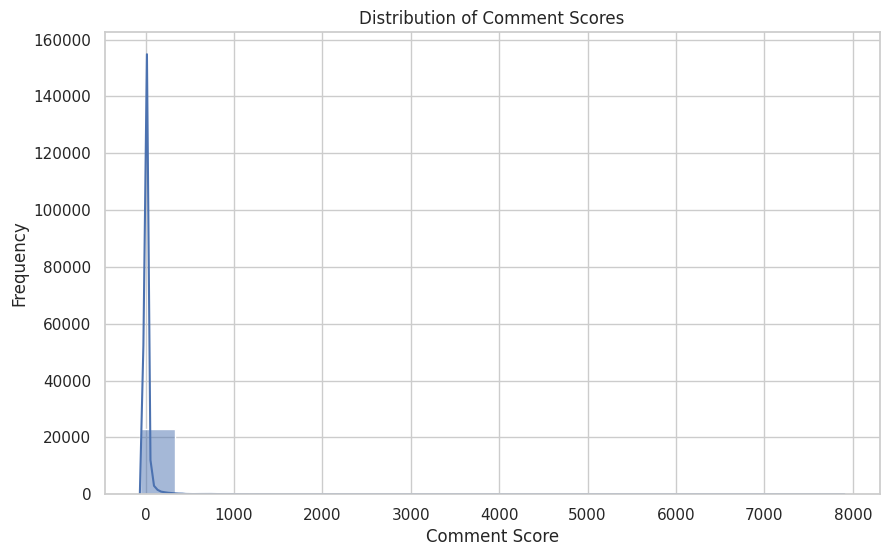

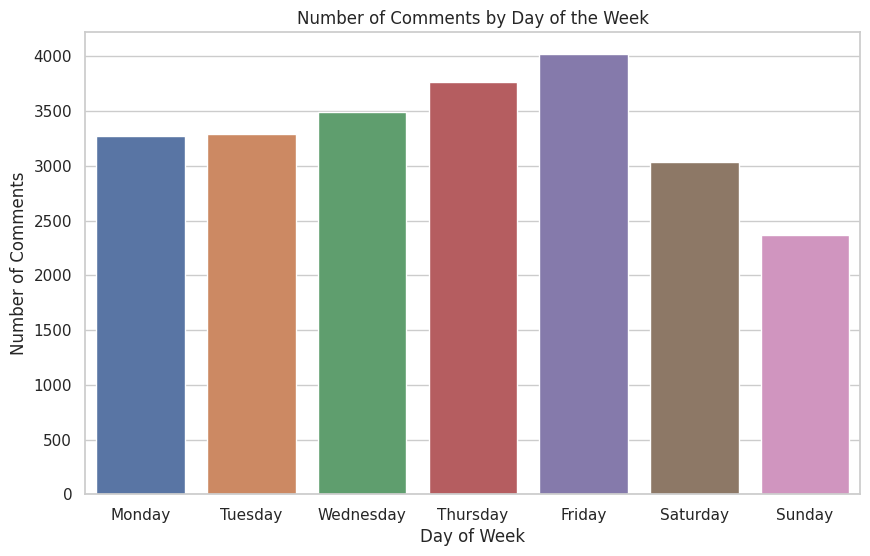

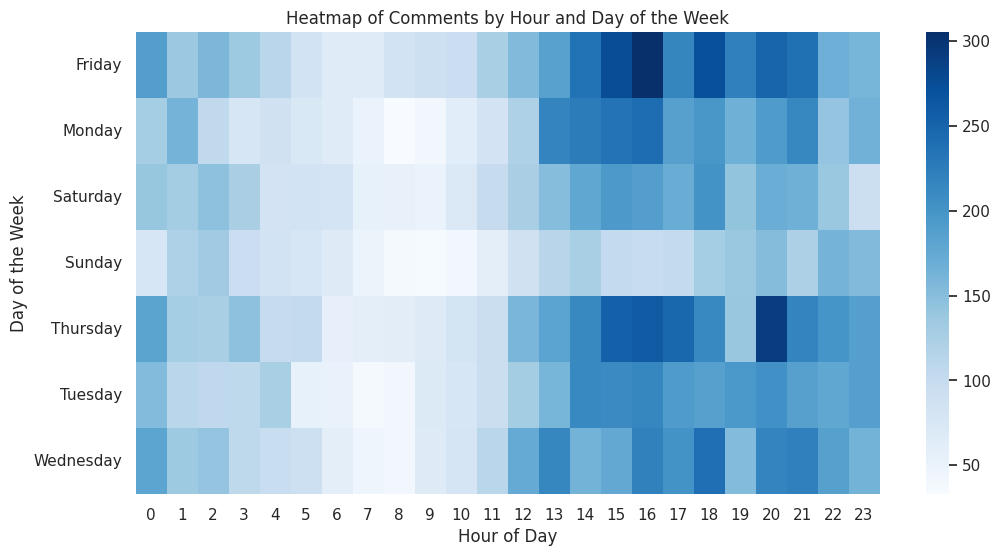

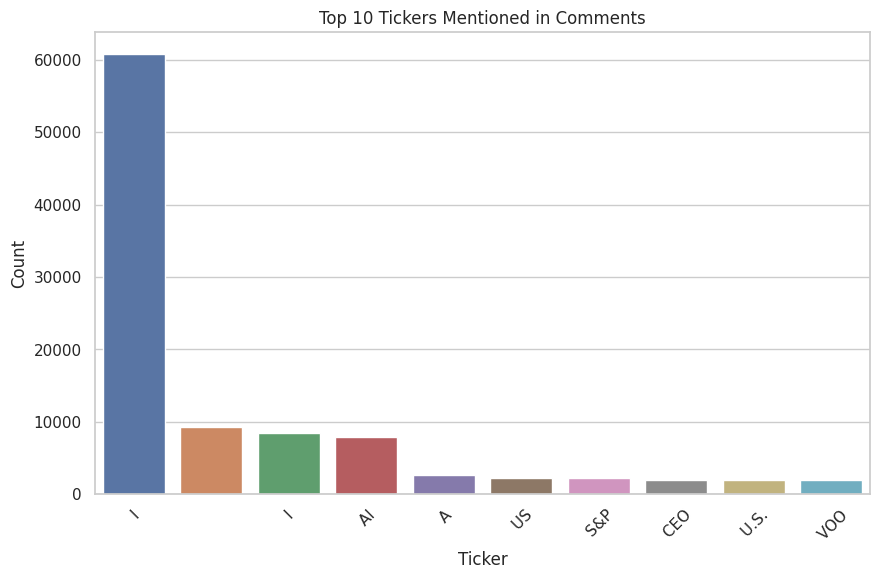

In [9]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv("/kaggle/input/50kcomments/reddit_stock_data_20240921_225227.csv")

# Convert datetime columns to datetime format
data['comment_comment_created_utc'] = pd.to_datetime(data['comment_comment_created_utc'])
data['created_utc'] = pd.to_datetime(data['created_utc'])

# Extract day of the week and hour of the day from datetime columns
data['comment_day_of_week'] = data['comment_comment_created_utc'].dt.day_name()
data['comment_hour_of_day'] = data['comment_comment_created_utc'].dt.hour

# Summary of the data
print(data.describe())
print(data.info())

# Distribution of comment scores
plt.figure(figsize=(10, 6))
sns.histplot(data['comment_comment_score'], bins=20, kde=True)
plt.title('Distribution of Comment Scores')
plt.xlabel('Comment Score')
plt.ylabel('Frequency')
plt.show()

# Posts by day of the week
plt.figure(figsize=(10, 6))
sns.countplot(x='comment_day_of_week', data=data, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of Comments by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Comments')
plt.show()

# Heatmap of comments by hour of the day and day of the week
heatmap_data = data.groupby(['comment_day_of_week', 'comment_hour_of_day']).size().unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Blues', annot=False)
plt.title('Heatmap of Comments by Hour and Day of the Week')
plt.ylabel('Day of the Week')
plt.xlabel('Hour of Day')
plt.show()

# Top tickers mentioned in comments
tickers_series = data['tickers'].dropna().str.split(',').explode()
top_tickers = tickers_series.value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_tickers.index, y=top_tickers.values)
plt.title('Top 10 Tickers Mentioned in Comments')
plt.xlabel('Ticker')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Sentiment analysis distribution (if applicable)
if 'sentiment' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='sentiment', data=data)
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()


In [6]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 3.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293632 sha256=a4fb59ffb8729030b768580dc647b3f662b4b123212722d2abe7f807da2fa59a
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from textblob import TextBlob
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler


In [17]:


# Load the scraped Reddit data
df = pd.read_csv('/kaggle/input/50kcomments/reddit_stock_data_20240921_225227.csv')

def preprocess_data(df):
    # Convert dates to datetime using the correct format
    df['created_utc'] = pd.to_datetime(df['created_utc'], format='%Y-%m-%d %H:%M:%S')
    
    # Combine title and body for sentiment analysis
    df['full_text'] = df['title'] + ' ' + df['body'].fillna('')
    
    # Perform sentiment analysis using TextBlob
    df['sentiment'] = df['full_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # Extract time-based features after converting datetime
    df['day_of_week'] = df['created_utc'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['hour_of_day'] = df['created_utc'].dt.hour       # 0-23 hours
    
    return df

def get_stock_data(symbol, start_date, end_date):
    # Fetch historical stock data using yfinance
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data['returns'] = stock_data['Close'].pct_change()  # Calculate daily returns
    return stock_data

def create_features(reddit_df, stock_df):
    # Aggregate Reddit data by date and tickers
    daily_reddit = reddit_df.groupby([reddit_df['created_utc'].dt.date, 'tickers']).agg({
        'sentiment': 'mean',           # Average sentiment per day
        'score': 'sum',                # Sum of upvotes (popularity)
        'num_comments': 'sum',         # Sum of comments (engagement)
        'day_of_week': 'first',        # Get the first day_of_week entry for each day
        'hour_of_day': 'first'         # Get the first hour_of_day entry for each day
    }).reset_index()
    
    # Merge Reddit data with stock data
    stock_df['created_utc'] = stock_df.index.date
    merged_df = pd.merge(daily_reddit, stock_df, left_on='created_utc', right_on='created_utc', how='inner')
    
    # Calculate moving averages
    merged_df['MA_10'] = merged_df['Close'].rolling(window=10).mean()
    merged_df['MA_50'] = merged_df['Close'].rolling(window=50).mean()
    
    # Create result column based on moving average crossover strategy
    merged_df['result'] = (merged_df['MA_10'] > merged_df['MA_50']).astype(int)
    
    return merged_df.dropna()


def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
#     model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
#     model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Build and train the neural network model
    model = create_model(X_train_scaled.shape[1])
    model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=2)
    
    # Evaluate the model
    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    print(classification_report(y_test, y_pred))
    
    return model

def main():
    # Load and preprocess Reddit data
    reddit_df = preprocess_data(df)
    
    # Get stock data (example: AAPL)
    start_date = reddit_df['created_utc'].min().strftime('%Y-%m-%d')
    end_date = reddit_df['created_utc'].max().strftime('%Y-%m-%d')
    stock_df = get_stock_data('AAPL', start_date, end_date)
    
    # Create features by merging Reddit and stock data
    features_df = create_features(reddit_df, stock_df)
    
    # Prepare features and target variables for training
    X = features_df[['sentiment', 'score', 'num_comments', 'day_of_week', 'hour_of_day']]
    y = features_df['result']
    
    # Train the model and print results
    model = train_model(X, y)
    
    
if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 - 1s - 33ms/step - accuracy: 0.5265 - loss: 0.6933 - val_accuracy: 0.5250 - val_loss: 0.6917
Epoch 2/50
45/45 - 0s - 3ms/step - accuracy: 0.5740 - loss: 0.6826 - val_accuracy: 0.5625 - val_loss: 0.6804
Epoch 3/50
45/45 - 0s - 3ms/step - accuracy: 0.5782 - loss: 0.6796 - val_accuracy: 0.5625 - val_loss: 0.6777
Epoch 4/50
45/45 - 0s - 3ms/step - accuracy: 0.5810 - loss: 0.6772 - val_accuracy: 0.5625 - val_loss: 0.6779
Epoch 5/50
45/45 - 0s - 3ms/step - accuracy: 0.5880 - loss: 0.6729 - val_accuracy: 0.5750 - val_loss: 0.6814
Epoch 6/50
45/45 - 0s - 3ms/step - accuracy: 0.5894 - loss: 0.6705 - val_accuracy: 0.5875 - val_loss: 0.6781
Epoch 7/50
45/45 - 0s - 3ms/step - accuracy: 0.5852 - loss: 0.6688 - val_accuracy: 0.5750 - val_loss: 0.6778
Epoch 8/50
45/45 - 0s - 3ms/step - accuracy: 0.6117 - loss: 0.6640 - val_accuracy: 0.5625 - val_loss: 0.6821
Epoch 9/50
45/45 - 0s - 3ms/step - accuracy: 0.6020 - loss: 0.6624 - val_accuracy: 0.5625 - val_loss: 0.6727
Epoch 10/50
45/45 - 0s - 3ms/

In [14]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import yfinance as yf
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import xgboost as xgb

In [16]:

# Load the scraped Reddit data
df = pd.read_csv('/kaggle/input/50kcomments/reddit_stock_data_20240921_225227.csv')

def preprocess_data(df):
    # Convert dates to datetime using the correct format
    df['created_utc'] = pd.to_datetime(df['created_utc'], format='%Y-%m-%d %H:%M:%S')
    
    # Combine title and body for sentiment analysis
    df['full_text'] = df['title'] + ' ' + df['body'].fillna('')
    
    # Perform sentiment analysis using TextBlob
    df['sentiment'] = df['full_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # Extract time-based features after converting datetime
    df['day_of_week'] = df['created_utc'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['hour_of_day'] = df['created_utc'].dt.hour       # 0-23 hours
    
    return df

def get_stock_data(symbol, start_date, end_date):
    # Fetch historical stock data using yfinance
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data['returns'] = stock_data['Close'].pct_change()  # Calculate daily returns
    return stock_data

def create_features(reddit_df, stock_df):
    # Aggregate Reddit data by date and tickers
    daily_reddit = reddit_df.groupby([reddit_df['created_utc'].dt.date, 'tickers']).agg({
        'sentiment': 'mean',
        'score': 'sum',
        'num_comments': 'sum',
        'day_of_week': 'first',
        'hour_of_day': 'first'
    }).reset_index()
    
    # Merge Reddit data with stock data
    stock_df['created_utc'] = stock_df.index.date
    merged_df = pd.merge(daily_reddit, stock_df, left_on='created_utc', right_on='created_utc', how='inner')
    
    # Calculate moving averages
    merged_df['MA_10'] = merged_df['Close'].rolling(window=10).mean()
    merged_df['MA_50'] = merged_df['Close'].rolling(window=50).mean()
    
    # Create result column based on moving average crossover strategy
    merged_df['result'] = (merged_df['MA_10'] > merged_df['MA_50']).astype(int)
    
    return merged_df.dropna()

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize classifiers
    classifiers = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'Support Vector Classifier': SVC(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }
    
    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))

def main():
    # Load and preprocess Reddit data
    reddit_df = preprocess_data(df)
    
    # Get stock data (example: AAPL)
    start_date = reddit_df['created_utc'].min().strftime('%Y-%m-%d')
    end_date = reddit_df['created_utc'].max().strftime('%Y-%m-%d')
    stock_df = get_stock_data('AAPL', start_date, end_date)
    
    # Create features by merging Reddit and stock data
    features_df = create_features(reddit_df, stock_df)
    
    # Prepare features and target variables for training
    X = features_df[['sentiment', 'score', 'num_comments', 'day_of_week', 'hour_of_day']]
    y = features_df['result']
    
    # Train the model and print results
    train_model(X, y)

if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.54      0.97      0.69       109

    accuracy                           0.53       200
   macro avg       0.27      0.49      0.35       200
weighted avg       0.29      0.53      0.38       200

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.45      0.49        91
           1       0.60      0.69      0.64       109

    accuracy                           0.58       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.58      0.58      0.57       200

Support Vector Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.15      0.24        91
           1       0.55      0.88      0.68       109

    accuracy                           0.55       

# greedy layerwise training

In [18]:
import pandas as pd
import yfinance as yf
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# Load the scraped Reddit data
df = pd.read_csv('/kaggle/input/50kcomments/reddit_stock_data_20240921_225227.csv')

def preprocess_data(df):
    # Convert dates to datetime using the correct format
    df['created_utc'] = pd.to_datetime(df['created_utc'], format='%Y-%m-%d %H:%M:%S')
    
    # Combine title and body for sentiment analysis
    df['full_text'] = df['title'] + ' ' + df['body'].fillna('')
    
    # Perform sentiment analysis using TextBlob
    df['sentiment'] = df['full_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # Extract time-based features after converting datetime
    df['day_of_week'] = df['created_utc'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['hour_of_day'] = df['created_utc'].dt.hour       # 0-23 hours
    
    return df

def get_stock_data(symbol, start_date, end_date):
    # Fetch historical stock data using yfinance
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data['returns'] = stock_data['Close'].pct_change()  # Calculate daily returns
    return stock_data

def create_features(reddit_df, stock_df):
    # Aggregate Reddit data by date and tickers
    daily_reddit = reddit_df.groupby([reddit_df['created_utc'].dt.date, 'tickers']).agg({
        'sentiment': 'mean',
        'score': 'sum',
        'num_comments': 'sum',
        'day_of_week': 'first',
        'hour_of_day': 'first'
    }).reset_index()
    
    # Merge Reddit data with stock data
    stock_df['created_utc'] = stock_df.index.date
    merged_df = pd.merge(daily_reddit, stock_df, left_on='created_utc', right_on='created_utc', how='inner')
    
    # Calculate moving averages
    merged_df['MA_10'] = merged_df['Close'].rolling(window=10).mean()
    merged_df['MA_50'] = merged_df['Close'].rolling(window=50).mean()
    
    # Create result column based on moving average crossover strategy
    merged_df['result'] = (merged_df['MA_10'] > merged_df['MA_50']).astype(int)
    
    return merged_df.dropna()

def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim, trainable=True))
    model.add(Dense(32, activation='relu', trainable=False))  # Initially, freeze this layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_layer(model, layer_index, X_train, y_train):
    # Unfreeze the current layer
    for i in range(len(model.layers)):
        model.layers[i].trainable = (i == layer_index)
    
    model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=2)

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Build the model
    model = create_model(X_train_scaled.shape[1])
    
    # Greedy layer-wise training
    for i in range(len(model.layers)):
        train_layer(model, i, X_train_scaled, y_train)
    
    # Evaluate the model
    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    print(classification_report(y_test, y_pred))
    
    return model

def main():
    # Load and preprocess Reddit data
    reddit_df = preprocess_data(df)
    
    # Get stock data (example: AAPL)
    start_date = reddit_df['created_utc'].min().strftime('%Y-%m-%d')
    end_date = reddit_df['created_utc'].max().strftime('%Y-%m-%d')
    stock_df = get_stock_data('AAPL', start_date, end_date)
    
    # Create features by merging Reddit and stock data
    features_df = create_features(reddit_df, stock_df)
    
    # Prepare features and target variables for training
    X = features_df[['sentiment', 'score', 'num_comments', 'day_of_week', 'hour_of_day']]
    y = features_df['result']
    
    # Train the model and print results
    model = train_model(X, y)
    
if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 - 1s - 23ms/step - accuracy: 0.5293 - loss: 0.6932 - val_accuracy: 0.6125 - val_loss: 0.6819
Epoch 2/50
45/45 - 0s - 3ms/step - accuracy: 0.5559 - loss: 0.6883 - val_accuracy: 0.5875 - val_loss: 0.6817
Epoch 3/50
45/45 - 0s - 3ms/step - accuracy: 0.5670 - loss: 0.6854 - val_accuracy: 0.5875 - val_loss: 0.6823
Epoch 4/50
45/45 - 0s - 3ms/step - accuracy: 0.5712 - loss: 0.6835 - val_accuracy: 0.5875 - val_loss: 0.6809
Epoch 5/50
45/45 - 0s - 3ms/step - accuracy: 0.5754 - loss: 0.6820 - val_accuracy: 0.5875 - val_loss: 0.6823
Epoch 6/50
45/45 - 0s - 2ms/step - accuracy: 0.5796 - loss: 0.6803 - val_accuracy: 0.5875 - val_loss: 0.6815
Epoch 7/50
45/45 - 0s - 3ms/step - accuracy: 0.5768 - loss: 0.6794 - val_accuracy: 0.5875 - val_loss: 0.6821
Epoch 8/50
45/45 - 0s - 3ms/step - accuracy: 0.5754 - loss: 0.6784 - val_accuracy: 0.5875 - val_loss: 0.6821
Epoch 9/50
45/45 - 0s - 3ms/step - accuracy: 0.5782 - loss: 0.6775 - val_accuracy: 0.5875 - val_loss: 0.6813
Epoch 10/50
45/45 - 0s - 3ms/

In [3]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 6.3 MB/s eta 0:00:00a 0:00:01


# Bert tokenizer

In [1]:
!pip install transformers torch
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 4.2 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=275728 sha256=8f2b19288914a624f12522ea4b4f67b6f6e31ce4ed1e25f2f7d5276db5ca208d
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


In [4]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType

In [8]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Load the scraped Reddit data
df = pd.read_csv('/kaggle/input/50kcomments/reddit_stock_data_20240921_225227.csv')

def preprocess_data(df):
    # Convert dates to datetime using the correct format
    df['created_utc'] = pd.to_datetime(df['created_utc'], format='%Y-%m-%d %H:%M:%S')
    
    # Combine title and body for sentiment analysis
    df['full_text'] = df['title'] + ' ' + df['body'].fillna('')
    
    # Extract time-based features after converting datetime
    df['day_of_week'] = df['created_utc'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['hour_of_day'] = df['created_utc'].dt.hour       # 0-23 hours
    
    return df

def analyze_sentiment(texts, batch_size=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        torch_dtype=torch.float16
    ).to(device)

    dataset = TensorDataset(torch.arange(len(texts)))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    predictions = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Analyzing sentiment"):
            batch_texts = [texts[i] for i in batch[0]]
            inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy().tolist())

    return predictions

def get_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data['returns'] = stock_data['Close'].pct_change()
    return stock_data

def create_features(reddit_df, stock_df):
    # Ensure 'day_of_week' and 'hour_of_day' are present in reddit_df after preprocessing
    if 'day_of_week' not in reddit_df.columns or 'hour_of_day' not in reddit_df.columns:
        raise KeyError("Columns ['day_of_week', 'hour_of_day'] are missing from reddit_df")
    
    # Aggregate Reddit data by date and tickers
    daily_reddit = reddit_df.groupby([reddit_df['created_utc'].dt.date, 'tickers']).agg({
        'sentiment': 'mean',
        'score': 'sum',
        'num_comments': 'sum',
        'day_of_week': 'first',   # Ensure the first day_of_week per group is taken
        'hour_of_day': 'first'    # Ensure the first hour_of_day per group is taken
    }).reset_index()
    
    stock_df['created_utc'] = stock_df.index.date
    merged_df = pd.merge(daily_reddit, stock_df, left_on='created_utc', right_on='created_utc', how='inner')
    
    # Calculate moving averages
    merged_df['MA_10'] = merged_df['Close'].rolling(window=10).mean()
    merged_df['MA_50'] = merged_df['Close'].rolling(window=50).mean()
    
    # Create result column based on moving average crossover strategy
    merged_df['result'] = (merged_df['MA_10'] > merged_df['MA_50']).astype(int)
    
    return merged_df.dropna()

def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = create_model(X_train_scaled.shape[1])
    model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=2)
    
    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    print(classification_report(y_test, y_pred))
    
    return model

def main():
    print("Preprocessing data...")
    reddit_df = preprocess_data(df)
    
    print("Analyzing sentiment...")
    reddit_df['sentiment'] = analyze_sentiment(reddit_df['full_text'].tolist())
    
    start_date = reddit_df['created_utc'].min().strftime('%Y-%m-%d')
    end_date = reddit_df['created_utc'].max().strftime('%Y-%m-%d')
    print(f"Fetching stock data for AAPL from {start_date} to {end_date}...")
    stock_df = get_stock_data('AAPL', start_date, end_date)
    
    print("Creating features...")
    features_df = create_features(reddit_df, stock_df)
    
    X = features_df[['sentiment', 'score', 'num_comments', 'day_of_week', 'hour_of_day']]
    y = features_df['result']
    
    print("Training model...")
    model = train_model(X, y)

if __name__ == "__main__":
    main()


Preprocessing data...
Analyzing sentiment...


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please u

Fetching stock data for AAPL from 2024-07-24 to 2024-09-21...
Creating features...
Training model...
Epoch 1/30
23/23 - 3s - 140ms/step - accuracy: 0.5223 - loss: 0.6954 - val_accuracy: 0.5875 - val_loss: 0.6817
Epoch 2/30
23/23 - 0s - 4ms/step - accuracy: 0.5698 - loss: 0.6867 - val_accuracy: 0.5750 - val_loss: 0.6841
Epoch 3/30
23/23 - 0s - 4ms/step - accuracy: 0.5852 - loss: 0.6831 - val_accuracy: 0.5875 - val_loss: 0.6809
Epoch 4/30
23/23 - 0s - 4ms/step - accuracy: 0.5768 - loss: 0.6805 - val_accuracy: 0.5875 - val_loss: 0.6768
Epoch 5/30
23/23 - 0s - 3ms/step - accuracy: 0.5740 - loss: 0.6781 - val_accuracy: 0.6000 - val_loss: 0.6809
Epoch 6/30
23/23 - 0s - 4ms/step - accuracy: 0.5894 - loss: 0.6741 - val_accuracy: 0.6000 - val_loss: 0.6744
Epoch 7/30
23/23 - 0s - 3ms/step - accuracy: 0.5810 - loss: 0.6710 - val_accuracy: 0.5750 - val_loss: 0.6770
Epoch 8/30
23/23 - 0s - 6ms/step - accuracy: 0.6117 - loss: 0.6688 - val_accuracy: 0.5500 - val_loss: 0.6767
Epoch 9/30
23/23 - 0s - 3

In [2]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Load the scraped Reddit data
df = pd.read_csv('/kaggle/input/50kcomments/reddit_stock_data_20240921_225227.csv')

def preprocess_data(df):
    # Convert dates to datetime using the correct format
    df['created_utc'] = pd.to_datetime(df['created_utc'], format='%Y-%m-%d %H:%M:%S')
    
    # Combine title and body for sentiment analysis
    df['full_text'] = df['title'] + ' ' + df['body'].fillna('')
    
    # Extract time-based features after converting datetime
    df['day_of_week'] = df['created_utc'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['hour_of_day'] = df['created_utc'].dt.hour       # 0-23 hours
    
    return df

def analyze_sentiment(texts, batch_size=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        torch_dtype=torch.float16
    ).to(device)

    dataset = TensorDataset(torch.arange(len(texts)))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    predictions = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Analyzing sentiment"):
            batch_texts = [texts[i] for i in batch[0]]
            inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy().tolist())

    return predictions

def get_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data['returns'] = stock_data['Close'].pct_change()
    return stock_data

def create_features(reddit_df, stock_df):
    # Ensure 'day_of_week' and 'hour_of_day' are present in reddit_df after preprocessing
    if 'day_of_week' not in reddit_df.columns or 'hour_of_day' not in reddit_df.columns:
        raise KeyError("Columns ['day_of_week', 'hour_of_day'] are missing from reddit_df")
    
    # Aggregate Reddit data by date and tickers
    daily_reddit = reddit_df.groupby([reddit_df['created_utc'].dt.date, 'tickers']).agg({
        'sentiment': 'mean',
        'score': 'sum',
        'num_comments': 'sum',
        'day_of_week': 'first',   # Ensure the first day_of_week per group is taken
        'hour_of_day': 'first'    # Ensure the first hour_of_day per group is taken
    }).reset_index()
    
    stock_df['created_utc'] = stock_df.index.date
    merged_df = pd.merge(daily_reddit, stock_df, left_on='created_utc', right_on='created_utc', how='inner')
    
    # Calculate moving averages
    merged_df['MA_10'] = merged_df['Close'].rolling(window=10).mean()
    merged_df['MA_50'] = merged_df['Close'].rolling(window=50).mean()
    
    # Create result column based on moving average crossover strategy
    merged_df['result'] = (merged_df['MA_10'] > merged_df['MA_50']).astype(int)
    
    return merged_df.dropna()

def create_bert_model():
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=1,  # Binary classification
        output_attentions=False,
        output_hidden_states=False,
    )
    return model

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    
    # Tokenize and encode sequences
    def encode_sequences(texts):
        return tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
    
    # Encode training and testing data
    train_encodings = encode_sequences(X_train.astype(str).apply(' '.join, axis=1))
    test_encodings = encode_sequences(X_test.astype(str).apply(' '.join, axis=1))
    
    # Convert to PyTorch datasets
    train_dataset = TensorDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    test_dataset = TensorDataset(
        test_encodings['input_ids'],
        test_encodings['attention_mask'],
        torch.tensor(y_test.values, dtype=torch.float32)
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = create_bert_model().to(device)
    
    # Set up optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    # Training loop
    num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
    # Evaluation
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend((logits.squeeze() > 0).cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
    
    print(classification_report(actual_labels, predictions))
    
    return model

def main():
    print("Preprocessing data...")
    reddit_df = preprocess_data(df)
    
    print("Analyzing sentiment...")
    reddit_df['sentiment'] = analyze_sentiment(reddit_df['full_text'].tolist())
    
    start_date = reddit_df['created_utc'].min().strftime('%Y-%m-%d')
    end_date = reddit_df['created_utc'].max().strftime('%Y-%m-%d')
    print(f"Fetching stock data for AAPL from {start_date} to {end_date}...")
    stock_df = get_stock_data('AAPL', start_date, end_date)
    
    print("Creating features...")
    features_df = create_features(reddit_df, stock_df)
    
    X = features_df[['sentiment', 'score', 'num_comments', 'day_of_week', 'hour_of_day']]
    y = features_df['result']
    
    print("Training model...")
    model = train_model(X, y)

if __name__ == "__main__":
    main()

Preprocessing data...
Analyzing sentiment...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Fetching stock data for AAPL from 2024-07-24 to 2024-09-21...


[*********************100%***********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Creating features...
Training model...


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        91
         1.0       0.55      1.00      0.71       109

    accuracy                           0.55       200
   macro avg       0.27      0.50      0.35       200
weighted avg       0.30      0.55      0.38       200




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [3]:
df.head()

,comment_comment_id,comment_comment_body,comment_comment_score,comment_comment_author,comment_comment_created_utc,comment_tickers,subreddit,post_id,title,body,score,num_comments,created_utc,author,url,tickers,full_text,day_of_week,hour_of_day,sentiment
0,lo9am0c,"Totally depends on your financial situation, r...",4,JuiceByYou,2024-09-21 19:57:15,NaN,stocks,1fmanog,Do you sell stocks nearing retirement and move...,"So... If you are nearing your retirement age,,...",0,27,2024-09-21 19:20:15,West-Bodybuilder-867,https://www.reddit.com/r/stocks/comments/1fman...,"NVDA, AAPL, META, MSFT",Do you sell stocks nearing retirement and move...,5,19,0
1,lo981xc,"If you’re nearing retirement, then it maybe be...",3,Alert_Cost_836,2024-09-21 19:42:33,"NVDA,",stocks,1fmanog,Do you sell stocks nearing retirement and move...,"So... If you are nearing your retirement age,,...",0,27,2024-09-21 19:20:15,West-Bodybuilder-867,https://www.reddit.com/r/stocks/comments/1fman...,"NVDA, AAPL, META, MSFT",Do you sell stocks nearing retirement and move...,5,19,0
2,lo9brj6,I’m 63. I know how to invest and trade. I buy...,3,NativeDave63,2024-09-21 20:03:53,"I, I, ETFS, I, I, IRA, IRA, I",stocks,1fmanog,Do you sell stocks nearing retirement and move...,"So... If you are nearing your retirement age,,...",0,27,2024-09-21 19:20:15,West-Bodybuilder-867,https://www.reddit.com/r/stocks/comments/1fman...,"NVDA, AAPL, META, MSFT",Do you sell stocks nearing retirement and move...,5,19,0
3,lo9f92c,"Spy looks good, up 30% this year",1,doge_fps,2024-09-21 20:23:21,NaN,stocks,1fmanog,Do you sell stocks nearing retirement and move...,"So... If you are nearing your retirement age,,...",0,27,2024-09-21 19:20:15,West-Bodybuilder-867,https://www.reddit.com/r/stocks/comments/1fman...,"NVDA, AAPL, META, MSFT",Do you sell stocks nearing retirement and move...,5,19,0
4,lo9fi6l,I mean if you buy a SP500 ETF you automaticall...,1,Echo-Possible,2024-09-21 20:24:47,"I, SP500, ETF, NVDA,, AAPL,, MSFT,, META.",stocks,1fmanog,Do you sell stocks nearing retirement and move...,"So... If you are nearing your retirement age,,...",0,27,2024-09-21 19:20:15,West-Bodybuilder-867,https://www.reddit.com/r/stocks/comments/1fman...,"NVDA, AAPL, META, MSFT",Do you sell stocks nearing retirement and move...,5,19,0
